# Modeling Cas9 PID through RBM

In [1]:
import sys
import os
import random
import warnings
import subprocess
import time
import multiprocessing
sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

from itertools import product
from tqdm import tqdm_notebook
from random import shuffle
from copy import deepcopy

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from torchpgm.model import *
from torchpgm.edge import Edge
from torchpgm.layers import *
from torchpgm.graphic import draw_G
from torchpgm.data import RBMDataWithPAM, RBMData

from sklearn.metrics import * 
from sklearn.linear_model import *
from sklearn.multioutput import MultiOutputClassifier

from utils import *
from config import *


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [11]:
device = "cuda"
folder = f"{DATA}/vink"

batch_size = 300
Nh = 200
Npam = 5
n_epochs = 1000
start_supervision_epoch = 20
l1b = 0.0025
l2 = 0.05
lambda_pa = 0.00
lr = 0.0001

#l1b = .5
#l2 = 0.1

model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}"

## The Standard RBM

We load the data. More details about how to build these data file are provided in the appropriated notebook

In [ ]:
train_dataset = RBMData(f"{folder}/data.pt", subset = "train")
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = RBMData(f"{folder}/data.pt", subset = "val")
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

Starting point for the potentials

In [ ]:
q_pi, N_pi = train_dataset[0][0].size()

g_pi = torch.zeros(q_pi, N_pi)
for x_pi, _, w, _ in train_dataset:
    g_pi += w* x_pi
g_pi = np.log(1+g_pi)
W = sum(train_dataset.weights)
g_pi = (g_pi - g_pi.mean(0)[None]).flatten()/W

We load the model

In [ ]:
model_full_name = f"rbm_pid_h{Nh}_npam{Npam}"

pi = OneHotLayer(None, N=N_pi, q=q_pi, name="pi")
h = GaussianLayer(N=Nh, name="hidden")

E = [(pi.name, h.name)]
E.sort()

model_rbm = PI_RBM(layers= {pi.name: pi, h.name: h}, edges=E, name = model_full_name)
optimizer = optim.AdamW(model_rbm.parameters(), lr=lr)

model_rbm = model_rbm.to(device)
#best_epoch = 180
#model_rbm.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")
model_rbm.ais()

We train the model

In [ ]:
for epoch in range(1, n_epochs):
    model_rbm.train_epoch(optimizer, train_loader, train_dataset, 
                          regularizer = {"l1b" : l1b, "l2": l2, "l1b_pam": 0}, 
                          epoch = epoch, savepath=f"{folder}/weights/{model_full_name}")
    shuffle(train_dataset.x_m)

    if not epoch % 5:
        model_rbm.ais()
        model_rbm.val(val_loader, visible_layers, hidden_layers, epoch)

We evaluate the model

In [2]:
model_rbm.eval()
model_rbm.ais()

print("Training set")
model_rbm.val(train_loader, visible_layers, hidden_layers, 0)

print("Validation set")
model_rbm.val(val_loader, visible_layers, hidden_layers, 0)

model_rbm = model_rbm.to("cpu")
device = "cpu"

NameError: name 'model_rbm' is not defined

## The Semi-Supervised Learning RBM

We load the data. More details about how to build these data file are provided in the appropriated notebook

In [3]:
train_dataset = RBMData(f"{folder}/data.pt", subset = "train")    
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = RBMData(f"{folder}/data.pt", subset = "val")
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

train_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "train_labelled")
train_loader_labelled = DataLoader(train_dataset_labelled, batch_size = batch_size, shuffle = True)

val_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "val_labelled")
val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = batch_size, shuffle = False)

Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y


Starting point for the potentials

In [4]:
q_pi, N_pi = train_dataset[0][0].size()
g_pi = torch.zeros(q_pi, N_pi)
for x_pi, _, w, _ in train_dataset:
    g_pi += w* x_pi
g_pi = np.log(1+g_pi)
W = sum(train_dataset.weights)
g_pi = (g_pi - g_pi.mean(0)[None]).flatten()/W

We load the model

In [5]:
device = "cuda"

pi = OneHotLayer(g_pi, N=N_pi, q=q_pi, name="pi")
h = GaussianLayer(N=Nh, name="hidden")

classifier = PAM_classifier(Nh, Npam * 4, dropout = 0.)
E = [(pi.name, h.name)]
E.sort()

gamma = 5

model_rbm_ssl = PI_RBM_SSL(classifier, layers= {pi.name: pi, h.name: h}, edges=E, name = "")
optimizer = optim.AdamW(model_rbm_ssl.parameters(), lr=lr)
model_rbm_ssl = model_rbm_ssl.to(device)

We train the model using both training set :
- The set of unlabelled sequences
- The set of labelled sequences

In [ ]:
for epoch in range(1, 181):
    model_rbm_ssl.train_epoch_classifier(optimizer, train_loader, train_loader_labelled, train_dataset, train_dataset_labelled, 
                                     regularizer = {"l1b" : l1b, "l2":l2 , "l1b_pam": 0}, 
                                     epoch = epoch, savepath=f"{folder}/weights/{model_full_name}")
    shuffle(train_dataset_labelled.x_m)
    shuffle(train_dataset.x_m)

    if not epoch % 5:
        model_rbm_ssl.ais()
        model_rbm_ssl.val(val_loader, visible_layers, hidden_layers, epoch)
        model_rbm_ssl.val_classifier(val_loader_labelled, visible_layers, hidden_layers, epoch)

In [ ]:
model_rbm_ssl.eval()
model_rbm_ssl.ais()

print("Training set")
model_rbm_ssl.val(train_loader, visible_layers, hidden_layers, 0)
model_rbm_ssl.val_classifier(train_loader_labelled, visible_layers, hidden_layers, 0)

print("Validation set")
model_rbm_ssl.val(val_loader, visible_layers, hidden_layers, 0)
model_rbm_ssl.val_classifier(val_loader_labelled, visible_layers, hidden_layers, 0)

model_rbm = model_rbm.to("cpu")
device = "cpu"

## Study on the effect of gamma on the quality of the model

For each value of $\gamma$, we train one SSL-RBM on the same training and validation sets. Training also possible using the script `train_all_rbm.py`

In [ ]:
for gamma in gammas:
    torch.cuda.empty_cache()
    train_dataset = RBMData(f"{folder}/data.pt", subset = "train" )
    train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True, drop_last=True)

    val_dataset = RBMData(f"{folder}/data.pt", subset = "val")
    val_loader = DataLoader(val_dataset, batch_size = 300, shuffle = False)

    train_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "train_labelled")
    train_loader_labelled = DataLoader(train_dataset_labelled, batch_size = 11, shuffle = True, drop_last=True)

    val_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "val_labelled")
    val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = 300, shuffle = False)
    
    q_pi, N_pi = train_dataset[0][0].size()
    g_pi = torch.zeros(q_pi, N_pi)
    for x_pi, _, w, _ in train_dataset:
        g_pi += w* x_pi
    g_pi = np.log(1+g_pi)
    W = sum(train_dataset.weights)
    g_pi = (g_pi - g_pi.mean(0)[None]).flatten()/W
    
    device = "cuda"
    folder = f"{DATA}/cas9/vink"
    model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}"    
    visible_layers = ["pi"]
    hidden_layers = ["hidden"]

    pi = OneHotLayer(None, N=N_pi, q=q_pi, name="pi")
    h = GaussianLayer(N=Nh, name="hidden")
    classifier = PAM_classifier(Nh, Npam * 4, dropout = 0.)
    E = [(pi.name, h.name)]
    E.sort()

    model_rbm = PI_RBM_SSL(classifier, layers= {pi.name: pi, h.name: h}, edges=E, gamma = gamma, name = f"classifier_{model_full_name}")
    optimizer = optim.AdamW(model_rbm.parameters(), lr=lr)
    model_rbm = model_rbm.to("cuda")
    model_rbm.ais()
    
    for epoch in range(1, 181):
        model_rbm.train_epoch_classifier(optimizer, train_loader, train_loader_labelled, train_dataset, train_dataset_labelled, 
                                         regularizer = {"l1b" : l1b, "l2":l2 , "l1b_pam": 0}, 
                                         epoch = epoch, savepath=f"{folder}/weights/c{model_full_name}")
        shuffle(train_dataset_labelled.x_m)
        shuffle(train_dataset.x_m)

        if not epoch % 5:
            model_rbm.ais()
            model_rbm.val(val_loader, visible_layers, hidden_layers, epoch)
            model_rbm.val_classifier(val_loader_labelled, visible_layers, hidden_layers, epoch)

Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Train SSL Epoch: 1 [100%] || Time: 0 min 1 || Loss: 0.659 || P(v): -3.276 || Reg: 0.637 || PI: 0.051  || PAM: 0.530
Train SSL Epoch: 2 [100%] || Time: 0 min 1 || Loss: 0.497 || P(v): -3.181 || Reg: 0.523 || PI: 0.062  || PAM: 0.535
Train SSL Epoch: 3 [100%] || Time: 0 min 0 || Loss: 0.309 || P(v): -2.976 || Reg: 0.432 || PI: 0.096  || PAM: 0.576
Train SSL Epoch: 4 [100%] || Time: 0 min 0 || Loss: 0.072 || P(v): -2.632 || Reg: 0.360 || PI: 0.191  || PAM: 0.591
Train SSL Epoch: 5 [100%] || Time: 0 min 0 || Loss: -0.234 || P(v): -2.118 || Reg: 0.304 || PI: 0.392  || PAM: 0.642
Val Epoch: 5 [100%] || Time: 0 min 0 || P(v): -1.808 || P(v,h): -1.944 || PI: 0.503
Val SSL Epoch: 5 [100%] || Time: 0 min 0 || P(v): -1.888 || P(v,h): -2.027 || PI: 0.496 || PAM: 0.699
Train SSL Epoch: 6 [100%] || Time

Train SSL Epoch: 106 [100%] || Time: 0 min 1 || Loss: 0.003 || P(v): -0.382 || Reg: 0.023 || PI: 0.737  || PAM: 0.883
Train SSL Epoch: 107 [100%] || Time: 0 min 1 || Loss: 0.008 || P(v): -0.376 || Reg: 0.023 || PI: 0.740  || PAM: 0.847
Train SSL Epoch: 108 [100%] || Time: 0 min 0 || Loss: 0.003 || P(v): -0.384 || Reg: 0.023 || PI: 0.739  || PAM: 0.892
Train SSL Epoch: 109 [100%] || Time: 0 min 0 || Loss: 0.003 || P(v): -0.381 || Reg: 0.023 || PI: 0.739  || PAM: 0.869
Train SSL Epoch: 110 [100%] || Time: 0 min 1 || Loss: 0.007 || P(v): -0.387 || Reg: 0.023 || PI: 0.739  || PAM: 0.858
Val Epoch: 110 [100%] || Time: 0 min 0 || P(v): -0.391 || P(v,h): -0.525 || PI: 0.734
Val SSL Epoch: 110 [100%] || Time: 0 min 0 || P(v): -0.512 || P(v,h): -0.641 || PI: 0.733 || PAM: 0.767
Train SSL Epoch: 111 [100%] || Time: 0 min 0 || Loss: -0.002 || P(v): -0.386 || Reg: 0.023 || PI: 0.740  || PAM: 0.889
Train SSL Epoch: 112 [100%] || Time: 0 min 0 || Loss: 0.009 || P(v): -0.385 || Reg: 0.023 || PI: 0.74

Train SSL Epoch: 31 [100%] || Time: 0 min 1 || Loss: 0.100 || P(v): 1.274 || Reg: 0.068 || PI: 0.695  || PAM: 0.519
Train SSL Epoch: 32 [100%] || Time: 0 min 1 || Loss: 0.087 || P(v): 1.149 || Reg: 0.066 || PI: 0.694  || PAM: 0.493
Train SSL Epoch: 33 [100%] || Time: 0 min 1 || Loss: 0.088 || P(v): 1.031 || Reg: 0.065 || PI: 0.694  || PAM: 0.501
Train SSL Epoch: 34 [100%] || Time: 0 min 1 || Loss: 0.083 || P(v): 0.911 || Reg: 0.063 || PI: 0.694  || PAM: 0.499
Train SSL Epoch: 35 [100%] || Time: 0 min 0 || Loss: 0.092 || P(v): 0.791 || Reg: 0.062 || PI: 0.694  || PAM: 0.536
Val Epoch: 35 [100%] || Time: 0 min 0 || P(v): 1.448 || P(v,h): 1.312 || PI: 0.697
Val SSL Epoch: 35 [100%] || Time: 0 min 0 || P(v): 1.253 || P(v,h): 1.120 || PI: 0.688 || PAM: 0.522
Train SSL Epoch: 36 [100%] || Time: 0 min 1 || Loss: 0.075 || P(v): 1.390 || Reg: 0.061 || PI: 0.694  || PAM: 0.537
Train SSL Epoch: 37 [100%] || Time: 0 min 1 || Loss: 0.089 || P(v): 1.283 || Reg: 0.059 || PI: 0.695  || PAM: 0.504
Trai

Train SSL Epoch: 136 [100%] || Time: 0 min 0 || Loss: -0.024 || P(v): -0.268 || Reg: 0.035 || PI: 0.750  || PAM: 0.817
Train SSL Epoch: 137 [100%] || Time: 0 min 1 || Loss: -0.038 || P(v): -0.258 || Reg: 0.035 || PI: 0.752  || PAM: 0.790
Train SSL Epoch: 138 [100%] || Time: 0 min 0 || Loss: -0.019 || P(v): -0.262 || Reg: 0.035 || PI: 0.751  || PAM: 0.750
Train SSL Epoch: 139 [100%] || Time: 0 min 0 || Loss: -0.012 || P(v): -0.259 || Reg: 0.035 || PI: 0.752  || PAM: 0.770
Train SSL Epoch: 140 [100%] || Time: 0 min 0 || Loss: -0.021 || P(v): -0.258 || Reg: 0.035 || PI: 0.751  || PAM: 0.766
Val Epoch: 140 [100%] || Time: 0 min 0 || P(v): -0.277 || P(v,h): -0.414 || PI: 0.745
Val SSL Epoch: 140 [100%] || Time: 0 min 0 || P(v): -0.418 || P(v,h): -0.545 || PI: 0.751 || PAM: 0.692
Train SSL Epoch: 141 [100%] || Time: 0 min 0 || Loss: -0.027 || P(v): -0.259 || Reg: 0.035 || PI: 0.751  || PAM: 0.793
Train SSL Epoch: 142 [100%] || Time: 0 min 0 || Loss: -0.007 || P(v): -0.262 || Reg: 0.035 || PI

Train SSL Epoch: 61 [100%] || Time: 0 min 1 || Loss: 0.022 || P(v): 0.339 || Reg: 0.041 || PI: 0.699  || PAM: 0.670
Train SSL Epoch: 62 [100%] || Time: 0 min 1 || Loss: 0.023 || P(v): 0.306 || Reg: 0.040 || PI: 0.700  || PAM: 0.674
Train SSL Epoch: 63 [100%] || Time: 0 min 1 || Loss: 0.022 || P(v): 0.271 || Reg: 0.040 || PI: 0.700  || PAM: 0.652
Train SSL Epoch: 64 [100%] || Time: 0 min 0 || Loss: 0.016 || P(v): 0.239 || Reg: 0.040 || PI: 0.700  || PAM: 0.662
Train SSL Epoch: 65 [100%] || Time: 0 min 0 || Loss: 0.016 || P(v): 0.208 || Reg: 0.039 || PI: 0.701  || PAM: 0.671
Val Epoch: 65 [100%] || Time: 0 min 0 || P(v): 0.219 || P(v,h): 0.085 || PI: 0.702
Val SSL Epoch: 65 [100%] || Time: 0 min 0 || P(v): 0.079 || P(v,h): -0.055 || PI: 0.696 || PAM: 0.675
Train SSL Epoch: 66 [100%] || Time: 0 min 1 || Loss: 0.011 || P(v): 0.192 || Reg: 0.039 || PI: 0.702  || PAM: 0.667
Train SSL Epoch: 67 [100%] || Time: 0 min 1 || Loss: 0.012 || P(v): 0.166 || Reg: 0.039 || PI: 0.702  || PAM: 0.679
Tra

Train SSL Epoch: 166 [100%] || Time: 0 min 0 || Loss: -0.008 || P(v): -0.238 || Reg: 0.034 || PI: 0.755  || PAM: 0.800
Train SSL Epoch: 167 [100%] || Time: 0 min 0 || Loss: -0.017 || P(v): -0.226 || Reg: 0.034 || PI: 0.756  || PAM: 0.794
Train SSL Epoch: 168 [100%] || Time: 0 min 1 || Loss: -0.017 || P(v): -0.224 || Reg: 0.034 || PI: 0.757  || PAM: 0.784
Train SSL Epoch: 169 [100%] || Time: 0 min 1 || Loss: -0.026 || P(v): -0.231 || Reg: 0.034 || PI: 0.756  || PAM: 0.801
Train SSL Epoch: 170 [100%] || Time: 0 min 1 || Loss: -0.017 || P(v): -0.231 || Reg: 0.034 || PI: 0.756  || PAM: 0.791
Val Epoch: 170 [100%] || Time: 0 min 0 || P(v): -0.245 || P(v,h): -0.380 || PI: 0.750
Val SSL Epoch: 170 [100%] || Time: 0 min 0 || P(v): -0.394 || P(v,h): -0.536 || PI: 0.749 || PAM: 0.698
Train SSL Epoch: 171 [100%] || Time: 0 min 1 || Loss: -0.004 || P(v): -0.218 || Reg: 0.035 || PI: 0.757  || PAM: 0.794
Train SSL Epoch: 172 [100%] || Time: 0 min 0 || Loss: -0.005 || P(v): -0.227 || Reg: 0.035 || PI

Train SSL Epoch: 91 [100%] || Time: 0 min 1 || Loss: -0.007 || P(v): -0.216 || Reg: 0.035 || PI: 0.730  || PAM: 0.758
Train SSL Epoch: 92 [100%] || Time: 0 min 1 || Loss: -0.021 || P(v): -0.229 || Reg: 0.035 || PI: 0.731  || PAM: 0.752
Train SSL Epoch: 93 [100%] || Time: 0 min 1 || Loss: -0.014 || P(v): -0.233 || Reg: 0.035 || PI: 0.732  || PAM: 0.781
Train SSL Epoch: 94 [100%] || Time: 0 min 0 || Loss: -0.008 || P(v): -0.233 || Reg: 0.035 || PI: 0.732  || PAM: 0.773
Train SSL Epoch: 95 [100%] || Time: 0 min 1 || Loss: -0.013 || P(v): -0.241 || Reg: 0.035 || PI: 0.732  || PAM: 0.762
Val Epoch: 95 [100%] || Time: 0 min 0 || P(v): -0.236 || P(v,h): -0.373 || PI: 0.730
Val SSL Epoch: 95 [100%] || Time: 0 min 0 || P(v): -0.375 || P(v,h): -0.510 || PI: 0.726 || PAM: 0.719
Train SSL Epoch: 96 [100%] || Time: 0 min 1 || Loss: -0.019 || P(v): -0.251 || Reg: 0.035 || PI: 0.733  || PAM: 0.716
Train SSL Epoch: 97 [100%] || Time: 0 min 1 || Loss: -0.013 || P(v): -0.256 || Reg: 0.035 || PI: 0.734  

Train SSL Epoch: 14 [100%] || Time: 0 min 0 || Loss: -0.843 || P(v): 1.792 || Reg: 0.127 || PI: 0.706  || PAM: 0.528
Train SSL Epoch: 15 [100%] || Time: 0 min 0 || Loss: -0.839 || P(v): 1.858 || Reg: 0.117 || PI: 0.706  || PAM: 0.468
Val Epoch: 15 [100%] || Time: 0 min 0 || P(v): 1.705 || P(v,h): 1.567 || PI: 0.707
Val SSL Epoch: 15 [100%] || Time: 0 min 0 || P(v): 1.443 || P(v,h): 1.314 || PI: 0.700 || PAM: 0.554
Train SSL Epoch: 16 [100%] || Time: 0 min 0 || Loss: -0.823 || P(v): 1.757 || Reg: 0.109 || PI: 0.705  || PAM: 0.543
Train SSL Epoch: 17 [100%] || Time: 0 min 0 || Loss: -0.640 || P(v): 1.843 || Reg: 0.102 || PI: 0.704  || PAM: 0.525
Train SSL Epoch: 18 [100%] || Time: 0 min 1 || Loss: -0.658 || P(v): 1.921 || Reg: 0.096 || PI: 0.703  || PAM: 0.529
Train SSL Epoch: 19 [100%] || Time: 0 min 1 || Loss: -0.537 || P(v): 2.020 || Reg: 0.091 || PI: 0.703  || PAM: 0.503
Train SSL Epoch: 20 [100%] || Time: 0 min 1 || Loss: -0.310 || P(v): 2.054 || Reg: 0.088 || PI: 0.701  || PAM: 0.4

Train SSL Epoch: 120 [100%] || Time: 0 min 1 || Loss: -0.028 || P(v): -0.293 || Reg: 0.034 || PI: 0.744  || PAM: 0.764
Val Epoch: 120 [100%] || Time: 0 min 0 || P(v): -0.300 || P(v,h): -0.436 || PI: 0.738
Val SSL Epoch: 120 [100%] || Time: 0 min 0 || P(v): -0.430 || P(v,h): -0.564 || PI: 0.739 || PAM: 0.757
Train SSL Epoch: 121 [100%] || Time: 0 min 1 || Loss: -0.031 || P(v): -0.285 || Reg: 0.034 || PI: 0.745  || PAM: 0.810
Train SSL Epoch: 122 [100%] || Time: 0 min 1 || Loss: -0.038 || P(v): -0.280 || Reg: 0.034 || PI: 0.746  || PAM: 0.806
Train SSL Epoch: 123 [100%] || Time: 0 min 0 || Loss: -0.035 || P(v): -0.277 || Reg: 0.034 || PI: 0.748  || PAM: 0.796
Train SSL Epoch: 124 [100%] || Time: 0 min 1 || Loss: -0.018 || P(v): -0.276 || Reg: 0.034 || PI: 0.748  || PAM: 0.784
Train SSL Epoch: 125 [100%] || Time: 0 min 0 || Loss: -0.023 || P(v): -0.278 || Reg: 0.034 || PI: 0.748  || PAM: 0.792
Val Epoch: 125 [100%] || Time: 0 min 0 || P(v): -0.295 || P(v,h): -0.429 || PI: 0.742
Val SSL Ep

Train SSL Epoch: 43 [100%] || Time: 0 min 1 || Loss: 0.066 || P(v): 1.268 || Reg: 0.053 || PI: 0.694  || PAM: 0.567
Train SSL Epoch: 44 [100%] || Time: 0 min 0 || Loss: 0.065 || P(v): 1.190 || Reg: 0.052 || PI: 0.695  || PAM: 0.535
Train SSL Epoch: 45 [100%] || Time: 0 min 0 || Loss: 0.063 || P(v): 1.109 || Reg: 0.051 || PI: 0.696  || PAM: 0.617
Val Epoch: 45 [100%] || Time: 0 min 0 || P(v): 1.360 || P(v,h): 1.222 || PI: 0.696
Val SSL Epoch: 45 [100%] || Time: 0 min 0 || P(v): 1.183 || P(v,h): 1.045 || PI: 0.686 || PAM: 0.559
Train SSL Epoch: 46 [100%] || Time: 0 min 0 || Loss: 0.060 || P(v): 1.308 || Reg: 0.050 || PI: 0.695  || PAM: 0.591
Train SSL Epoch: 47 [100%] || Time: 0 min 1 || Loss: 0.053 || P(v): 1.241 || Reg: 0.050 || PI: 0.694  || PAM: 0.562
Train SSL Epoch: 48 [100%] || Time: 0 min 1 || Loss: 0.055 || P(v): 1.169 || Reg: 0.049 || PI: 0.695  || PAM: 0.563
Train SSL Epoch: 49 [100%] || Time: 0 min 1 || Loss: 0.054 || P(v): 1.102 || Reg: 0.048 || PI: 0.695  || PAM: 0.602
Trai

Train SSL Epoch: 96 [100%] || Time: 0 min 0 || Loss: -0.013 || P(v): -0.149 || Reg: 0.035 || PI: 0.732  || PAM: 0.784
Train SSL Epoch: 97 [100%] || Time: 0 min 0 || Loss: -0.007 || P(v): -0.162 || Reg: 0.034 || PI: 0.733  || PAM: 0.793
Train SSL Epoch: 98 [100%] || Time: 0 min 0 || Loss: -0.009 || P(v): -0.172 || Reg: 0.034 || PI: 0.733  || PAM: 0.769
Train SSL Epoch: 99 [100%] || Time: 0 min 1 || Loss: -0.018 || P(v): -0.184 || Reg: 0.034 || PI: 0.733  || PAM: 0.737
Train SSL Epoch: 100 [100%] || Time: 0 min 1 || Loss: -0.017 || P(v): -0.192 || Reg: 0.034 || PI: 0.732  || PAM: 0.759
Val Epoch: 100 [100%] || Time: 0 min 0 || P(v): -0.181 || P(v,h): -0.315 || PI: 0.731
Val SSL Epoch: 100 [100%] || Time: 0 min 0 || P(v): -0.324 || P(v,h): -0.463 || PI: 0.728 || PAM: 0.775
Train SSL Epoch: 101 [100%] || Time: 0 min 1 || Loss: -0.006 || P(v): -0.198 || Reg: 0.034 || PI: 0.734  || PAM: 0.789
Train SSL Epoch: 102 [100%] || Time: 0 min 0 || Loss: -0.011 || P(v): -0.210 || Reg: 0.034 || PI: 0.

Train SSL Epoch: 19 [100%] || Time: 0 min 0 || Loss: -0.225 || P(v): 1.422 || Reg: 0.089 || PI: 0.700  || PAM: 0.547
Train SSL Epoch: 20 [100%] || Time: 0 min 0 || Loss: -0.188 || P(v): 1.392 || Reg: 0.085 || PI: 0.699  || PAM: 0.508
Val Epoch: 20 [100%] || Time: 0 min 0 || P(v): 1.674 || P(v,h): 1.537 || PI: 0.700
Val SSL Epoch: 20 [100%] || Time: 0 min 0 || P(v): 1.444 || P(v,h): 1.311 || PI: 0.691 || PAM: 0.488
Train SSL Epoch: 21 [100%] || Time: 0 min 0 || Loss: -0.007 || P(v): 1.656 || Reg: 0.081 || PI: 0.699  || PAM: 0.521
Train SSL Epoch: 22 [100%] || Time: 0 min 0 || Loss: -0.024 || P(v): 1.580 || Reg: 0.078 || PI: 0.698  || PAM: 0.475
Train SSL Epoch: 23 [100%] || Time: 0 min 0 || Loss: 0.038 || P(v): 1.480 || Reg: 0.075 || PI: 0.697  || PAM: 0.494
Train SSL Epoch: 24 [100%] || Time: 0 min 0 || Loss: 0.069 || P(v): 1.365 || Reg: 0.073 || PI: 0.696  || PAM: 0.511
Train SSL Epoch: 25 [100%] || Time: 0 min 0 || Loss: 0.107 || P(v): 1.231 || Reg: 0.071 || PI: 0.695  || PAM: 0.506


Train SSL Epoch: 125 [100%] || Time: 0 min 0 || Loss: -0.015 || P(v): -0.279 || Reg: 0.034 || PI: 0.748  || PAM: 0.799
Val Epoch: 125 [100%] || Time: 0 min 0 || P(v): -0.294 || P(v,h): -0.433 || PI: 0.744
Val SSL Epoch: 125 [100%] || Time: 0 min 0 || P(v): -0.426 || P(v,h): -0.561 || PI: 0.745 || PAM: 0.741
Train SSL Epoch: 126 [100%] || Time: 0 min 1 || Loss: -0.017 || P(v): -0.286 || Reg: 0.034 || PI: 0.749  || PAM: 0.764
Train SSL Epoch: 127 [100%] || Time: 0 min 1 || Loss: -0.028 || P(v): -0.277 || Reg: 0.034 || PI: 0.750  || PAM: 0.800
Train SSL Epoch: 128 [100%] || Time: 0 min 1 || Loss: -0.010 || P(v): -0.286 || Reg: 0.034 || PI: 0.749  || PAM: 0.816
Train SSL Epoch: 129 [100%] || Time: 0 min 1 || Loss: -0.032 || P(v): -0.292 || Reg: 0.034 || PI: 0.749  || PAM: 0.799
Train SSL Epoch: 130 [100%] || Time: 0 min 1 || Loss: -0.023 || P(v): -0.291 || Reg: 0.034 || PI: 0.750  || PAM: 0.801
Val Epoch: 130 [100%] || Time: 0 min 0 || P(v): -0.312 || P(v,h): -0.448 || PI: 0.744
Val SSL Ep

Train SSL Epoch: 48 [100%] || Time: 0 min 0 || Loss: 0.047 || P(v): 0.838 || Reg: 0.046 || PI: 0.694  || PAM: 0.597
Train SSL Epoch: 49 [100%] || Time: 0 min 0 || Loss: 0.043 || P(v): 0.783 || Reg: 0.045 || PI: 0.695  || PAM: 0.640
Train SSL Epoch: 50 [100%] || Time: 0 min 0 || Loss: 0.045 || P(v): 0.730 || Reg: 0.045 || PI: 0.696  || PAM: 0.596
Val Epoch: 50 [100%] || Time: 0 min 0 || P(v): 0.767 || P(v,h): 0.629 || PI: 0.698
Val SSL Epoch: 50 [100%] || Time: 0 min 0 || P(v): 0.611 || P(v,h): 0.473 || PI: 0.692 || PAM: 0.685
Train SSL Epoch: 51 [100%] || Time: 0 min 1 || Loss: 0.044 || P(v): 0.731 || Reg: 0.044 || PI: 0.696  || PAM: 0.635
Train SSL Epoch: 52 [100%] || Time: 0 min 1 || Loss: 0.043 || P(v): 0.677 || Reg: 0.044 || PI: 0.696  || PAM: 0.662
Train SSL Epoch: 53 [100%] || Time: 0 min 1 || Loss: 0.036 || P(v): 0.634 || Reg: 0.043 || PI: 0.696  || PAM: 0.629
Train SSL Epoch: 54 [100%] || Time: 0 min 0 || Loss: 0.037 || P(v): 0.586 || Reg: 0.043 || PI: 0.697  || PAM: 0.633
Trai

Train SSL Epoch: 101 [100%] || Time: 0 min 1 || Loss: -0.008 || P(v): -0.276 || Reg: 0.033 || PI: 0.734  || PAM: 0.812
Train SSL Epoch: 102 [100%] || Time: 0 min 1 || Loss: -0.024 || P(v): -0.277 || Reg: 0.033 || PI: 0.735  || PAM: 0.804
Train SSL Epoch: 103 [100%] || Time: 0 min 1 || Loss: -0.014 || P(v): -0.280 || Reg: 0.033 || PI: 0.736  || PAM: 0.825
Train SSL Epoch: 104 [100%] || Time: 0 min 1 || Loss: -0.012 || P(v): -0.286 || Reg: 0.033 || PI: 0.736  || PAM: 0.794
Train SSL Epoch: 105 [100%] || Time: 0 min 1 || Loss: -0.021 || P(v): -0.292 || Reg: 0.033 || PI: 0.735  || PAM: 0.797
Val Epoch: 105 [100%] || Time: 0 min 0 || P(v): -0.293 || P(v,h): -0.429 || PI: 0.730
Val SSL Epoch: 105 [100%] || Time: 0 min 0 || P(v): -0.430 || P(v,h): -0.570 || PI: 0.730 || PAM: 0.753
Train SSL Epoch: 106 [100%] || Time: 0 min 0 || Loss: -0.022 || P(v): -0.295 || Reg: 0.033 || PI: 0.737  || PAM: 0.779
Train SSL Epoch: 107 [100%] || Time: 0 min 0 || Loss: -0.024 || P(v): -0.296 || Reg: 0.033 || PI

Train SSL Epoch: 24 [100%] || Time: 0 min 0 || Loss: -0.184 || P(v): 1.606 || Reg: 0.075 || PI: 0.699  || PAM: 0.547
Train SSL Epoch: 25 [100%] || Time: 0 min 0 || Loss: -0.090 || P(v): 1.574 || Reg: 0.073 || PI: 0.699  || PAM: 0.575
Val Epoch: 25 [100%] || Time: 0 min 0 || P(v): 1.434 || P(v,h): 1.296 || PI: 0.700
Val SSL Epoch: 25 [100%] || Time: 0 min 0 || P(v): 1.187 || P(v,h): 1.048 || PI: 0.698 || PAM: 0.659
Train SSL Epoch: 26 [100%] || Time: 0 min 0 || Loss: -0.124 || P(v): 1.398 || Reg: 0.072 || PI: 0.698  || PAM: 0.596
Train SSL Epoch: 27 [100%] || Time: 0 min 0 || Loss: 0.027 || P(v): 1.306 || Reg: 0.070 || PI: 0.697  || PAM: 0.587
Train SSL Epoch: 28 [100%] || Time: 0 min 0 || Loss: -0.010 || P(v): 1.205 || Reg: 0.068 || PI: 0.696  || PAM: 0.568
Train SSL Epoch: 29 [100%] || Time: 0 min 0 || Loss: 0.050 || P(v): 1.103 || Reg: 0.067 || PI: 0.697  || PAM: 0.597
Train SSL Epoch: 30 [100%] || Time: 0 min 0 || Loss: 0.060 || P(v): 0.988 || Reg: 0.065 || PI: 0.697  || PAM: 0.585


Train SSL Epoch: 130 [100%] || Time: 0 min 1 || Loss: -0.029 || P(v): -0.280 || Reg: 0.033 || PI: 0.750  || PAM: 0.799
Val Epoch: 130 [100%] || Time: 0 min 0 || P(v): -0.296 || P(v,h): -0.432 || PI: 0.743
Val SSL Epoch: 130 [100%] || Time: 0 min 0 || P(v): -0.430 || P(v,h): -0.568 || PI: 0.746 || PAM: 0.776
Train SSL Epoch: 131 [100%] || Time: 0 min 1 || Loss: -0.027 || P(v): -0.285 || Reg: 0.033 || PI: 0.750  || PAM: 0.824
Train SSL Epoch: 132 [100%] || Time: 0 min 1 || Loss: -0.023 || P(v): -0.285 || Reg: 0.033 || PI: 0.750  || PAM: 0.747
Train SSL Epoch: 133 [100%] || Time: 0 min 1 || Loss: -0.029 || P(v): -0.281 || Reg: 0.033 || PI: 0.750  || PAM: 0.828
Train SSL Epoch: 134 [100%] || Time: 0 min 1 || Loss: -0.026 || P(v): -0.271 || Reg: 0.033 || PI: 0.752  || PAM: 0.809
Train SSL Epoch: 135 [100%] || Time: 0 min 1 || Loss: -0.031 || P(v): -0.279 || Reg: 0.033 || PI: 0.751  || PAM: 0.782
Val Epoch: 135 [100%] || Time: 0 min 0 || P(v): -0.303 || P(v,h): -0.439 || PI: 0.745
Val SSL Ep

Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Train SSL Epoch: 1 [100%] || Time: 0 min 1 || Loss: 0.628 || P(v): -3.267 || Reg: 0.638 || PI: 0.052  || PAM: 0.537
Train SSL Epoch: 2 [100%] || Time: 0 min 1 || Loss: 0.425 || P(v): -3.150 || Reg: 0.529 || PI: 0.066  || PAM: 0.502
Train SSL Epoch: 3 [100%] || Time: 0 min 1 || Loss: 0.146 || P(v): -2.917 || Reg: 0.443 || PI: 0.107  || PAM: 0.524
Train SSL Epoch: 4 [100%] || Time: 0 min 1 || Loss: -0.233 || P(v): -2.543 || Reg: 0.375 || PI: 0.216  || PAM: 0.523
Train SSL Epoch: 5 [100%] || Time: 0 min 1 || Loss: -0.730 || P(v): -2.017 || Reg: 0.321 || PI: 0.421  || PAM: 0.539
Val Epoch: 5 [100%] || Time: 0 min 0 || P(v): -1.714 || P(v,h): -1.850 || PI: 0.526
Val SSL Epoch: 5 [100%] || Time: 0 min 0 || P(v): -1.791 || P(v,h): -1.932 || PI: 0.517 || PAM: 0.612
Train SSL Epoch: 6 [100%] || Time: 0 min 0 || Loss: -1.355 || P(v): -1.320 || Reg:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train SSL Epoch: 49 [100%] || Time: 0 min 1 || Loss: 0.049 || P(v): 0.781 || Reg: 0.041 || PI: 0.697  || PAM: 0.736
Train SSL Epoch: 50 [100%] || Time: 0 min 0 || Loss: 0.042 || P(v): 0.722 || Reg: 0.040 || PI: 0.696  || PAM: 0.759
Val Epoch: 50 [100%] || Time: 0 min 0 || P(v): 0.849 || P(v,h): 0.714 || PI: 0.698
Val SSL Epoch: 50 [100%] || Time: 0 min 0 || P(v): 0.698 || P(v,h): 0.557 || PI: 0.691 || PAM: 0.758
Train SSL Epoch: 51 [100%] || Time: 0 min 0 || Loss: 0.040 || P(v): 0.810 || Reg: 0.040 || PI: 0.697  || PAM: 0.772
Train SSL Epoch: 52 [100%] || Time: 0 min 0 || Loss: 0.038 || P(v): 0.759 || Reg: 0.039 || PI: 0.698  || PAM: 0.768
Train SSL Epoch: 53 [100%] || Time: 0 min 1 || Loss: 0.038 || P(v): 0.714 || Reg: 0.039 || PI: 0.699  || PAM: 0.741
Train SSL Epoch: 54 [100%] || Time: 0 min 0 || Loss: 0.038 || P(v): 0.668 || Reg: 0.038 || PI: 0.700  || PAM: 0.765
Train SSL Epoch: 55 [100%] || Time: 0 min 1 || Loss: 0.035 || P(v): 0.617 || Reg: 0.038 || PI: 0.699  || PAM: 0.771
Val 

Train SSL Epoch: 153 [100%] || Time: 0 min 0 || Loss: 0.020 || P(v): -0.284 || Reg: 0.030 || PI: 0.754  || PAM: 0.834
Train SSL Epoch: 154 [100%] || Time: 0 min 1 || Loss: 0.009 || P(v): -0.281 || Reg: 0.030 || PI: 0.755  || PAM: 0.840
Train SSL Epoch: 155 [100%] || Time: 0 min 1 || Loss: -0.003 || P(v): -0.282 || Reg: 0.030 || PI: 0.754  || PAM: 0.866
Val Epoch: 155 [100%] || Time: 0 min 0 || P(v): -0.308 || P(v,h): -0.443 || PI: 0.747
Val SSL Epoch: 155 [100%] || Time: 0 min 0 || P(v): -0.441 || P(v,h): -0.575 || PI: 0.749 || PAM: 0.756
Train SSL Epoch: 156 [100%] || Time: 0 min 1 || Loss: -0.003 || P(v): -0.294 || Reg: 0.030 || PI: 0.754  || PAM: 0.855
Train SSL Epoch: 157 [100%] || Time: 0 min 0 || Loss: 0.000 || P(v): -0.297 || Reg: 0.030 || PI: 0.753  || PAM: 0.855
Train SSL Epoch: 158 [100%] || Time: 0 min 0 || Loss: -0.007 || P(v): -0.291 || Reg: 0.030 || PI: 0.754  || PAM: 0.877
Train SSL Epoch: 159 [100%] || Time: 0 min 0 || Loss: -0.008 || P(v): -0.290 || Reg: 0.030 || PI: 0

Train SSL Epoch: 77 [100%] || Time: 0 min 0 || Loss: -0.008 || P(v): 0.236 || Reg: 0.031 || PI: 0.722  || PAM: 0.792
Train SSL Epoch: 78 [100%] || Time: 0 min 1 || Loss: -0.010 || P(v): 0.215 || Reg: 0.031 || PI: 0.724  || PAM: 0.832
Train SSL Epoch: 79 [100%] || Time: 0 min 1 || Loss: -0.009 || P(v): 0.188 || Reg: 0.031 || PI: 0.725  || PAM: 0.835
Train SSL Epoch: 80 [100%] || Time: 0 min 1 || Loss: -0.007 || P(v): 0.161 || Reg: 0.031 || PI: 0.726  || PAM: 0.806
Val Epoch: 80 [100%] || Time: 0 min 0 || P(v): 0.163 || P(v,h): 0.027 || PI: 0.724
Val SSL Epoch: 80 [100%] || Time: 0 min 0 || P(v): 0.025 || P(v,h): -0.111 || PI: 0.721 || PAM: 0.792
Train SSL Epoch: 81 [100%] || Time: 0 min 0 || Loss: -0.004 || P(v): 0.140 || Reg: 0.031 || PI: 0.728  || PAM: 0.811
Train SSL Epoch: 82 [100%] || Time: 0 min 0 || Loss: 0.003 || P(v): 0.116 || Reg: 0.031 || PI: 0.728  || PAM: 0.828
Train SSL Epoch: 83 [100%] || Time: 0 min 1 || Loss: 0.002 || P(v): 0.085 || Reg: 0.030 || PI: 0.728  || PAM: 0.82

Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Available :  x pi_seq y L labelled subset weights
Train SSL Epoch: 1 [100%] || Time: 0 min 0 || Loss: 0.647 || P(v): -3.271 || Reg: 0.636 || PI: 0.052  || PAM: 0.534
Train SSL Epoch: 2 [100%] || Time: 0 min 1 || Loss: 0.471 || P(v): -3.167 || Reg: 0.524 || PI: 0.064  || PAM: 0.555
Train SSL Epoch: 3 [100%] || Time: 0 min 0 || Loss: 0.253 || P(v): -2.951 || Reg: 0.435 || PI: 0.102  || PAM: 0.581
Train SSL Epoch: 4 [100%] || Time: 0 min 0 || Loss: -0.035 || P(v): -2.591 || Reg: 0.365 || PI: 0.201  || PAM: 0.585
Train SSL Epoch: 5 [100%] || Time: 0 min 0 || Loss: -0.403 || P(v): -2.074 || Reg: 0.309 || PI: 0.405  || PAM: 0.600
Val Epoch: 5 [100%] || Time: 0 min 0 || P(v): -1.760 || P(v,h): -1.896 || PI: 0.516
Val SSL Epoch: 5 [100%] || Time: 0 min 0 || P(v): -1.850 || P(v,h): -1.981 || PI: 0.507 || PAM: 0.700
Train SSL Epoch: 6 [100%] || Time: 0 min 0 || Loss: -0.870 || P(v): -1.375 || Reg:

Train SSL Epoch: 106 [100%] || Time: 0 min 1 || Loss: -0.009 || P(v): -0.358 || Reg: 0.026 || PI: 0.737  || PAM: 0.859
Train SSL Epoch: 107 [100%] || Time: 0 min 0 || Loss: -0.009 || P(v): -0.355 || Reg: 0.026 || PI: 0.739  || PAM: 0.837
Train SSL Epoch: 108 [100%] || Time: 0 min 0 || Loss: -0.003 || P(v): -0.350 || Reg: 0.026 || PI: 0.740  || PAM: 0.838
Train SSL Epoch: 109 [100%] || Time: 0 min 0 || Loss: 0.004 || P(v): -0.350 || Reg: 0.026 || PI: 0.740  || PAM: 0.813
Train SSL Epoch: 110 [100%] || Time: 0 min 0 || Loss: -0.013 || P(v): -0.357 || Reg: 0.026 || PI: 0.740  || PAM: 0.866
Val Epoch: 110 [100%] || Time: 0 min 0 || P(v): -0.364 || P(v,h): -0.502 || PI: 0.735
Val SSL Epoch: 110 [100%] || Time: 0 min 0 || P(v): -0.492 || P(v,h): -0.632 || PI: 0.730 || PAM: 0.799
Train SSL Epoch: 111 [100%] || Time: 0 min 1 || Loss: -0.004 || P(v): -0.358 || Reg: 0.026 || PI: 0.742  || PAM: 0.841
Train SSL Epoch: 112 [100%] || Time: 0 min 1 || Loss: 0.000 || P(v): -0.356 || Reg: 0.026 || PI: 

Train SSL Epoch: 159 [100%] || Time: 0 min 0 || Loss: 0.001 || P(v): -0.313 || Reg: 0.027 || PI: 0.756  || PAM: 0.891
Train SSL Epoch: 160 [100%] || Time: 0 min 0 || Loss: 0.007 || P(v): -0.313 || Reg: 0.027 || PI: 0.756  || PAM: 0.850
Val Epoch: 160 [100%] || Time: 0 min 0 || P(v): -0.329 || P(v,h): -0.461 || PI: 0.749
Val SSL Epoch: 160 [100%] || Time: 0 min 0 || P(v): -0.464 || P(v,h): -0.601 || PI: 0.753 || PAM: 0.791
Train SSL Epoch: 161 [100%] || Time: 0 min 0 || Loss: 0.006 || P(v): -0.303 || Reg: 0.027 || PI: 0.757  || PAM: 0.864
Train SSL Epoch: 162 [100%] || Time: 0 min 0 || Loss: 0.003 || P(v): -0.312 || Reg: 0.027 || PI: 0.757  || PAM: 0.883
Train SSL Epoch: 163 [100%] || Time: 0 min 1 || Loss: 0.006 || P(v): -0.308 || Reg: 0.027 || PI: 0.757  || PAM: 0.874
Train SSL Epoch: 164 [100%] || Time: 0 min 0 || Loss: -0.002 || P(v): -0.304 || Reg: 0.027 || PI: 0.757  || PAM: 0.893
Train SSL Epoch: 165 [100%] || Time: 0 min 1 || Loss: 0.001 || P(v): -0.306 || Reg: 0.027 || PI: 0.75

Train SSL Epoch: 31 [100%] || Time: 0 min 0 || Loss: 0.075 || P(v): 1.534 || Reg: 0.044 || PI: 0.696  || PAM: 0.760
Train SSL Epoch: 32 [100%] || Time: 0 min 0 || Loss: 0.072 || P(v): 1.434 || Reg: 0.043 || PI: 0.695  || PAM: 0.733
Train SSL Epoch: 33 [100%] || Time: 0 min 1 || Loss: 0.066 || P(v): 1.345 || Reg: 0.042 || PI: 0.696  || PAM: 0.815
Train SSL Epoch: 34 [100%] || Time: 0 min 1 || Loss: 0.063 || P(v): 1.261 || Reg: 0.041 || PI: 0.696  || PAM: 0.759
Train SSL Epoch: 35 [100%] || Time: 0 min 1 || Loss: 0.063 || P(v): 1.187 || Reg: 0.040 || PI: 0.697  || PAM: 0.796
Val Epoch: 35 [100%] || Time: 0 min 0 || P(v): 1.219 || P(v,h): 1.083 || PI: 0.699
Val SSL Epoch: 35 [100%] || Time: 0 min 0 || P(v): 1.048 || P(v,h): 0.908 || PI: 0.693 || PAM: 0.802
Train SSL Epoch: 36 [100%] || Time: 0 min 0 || Loss: 0.061 || P(v): 1.166 || Reg: 0.039 || PI: 0.697  || PAM: 0.754
Train SSL Epoch: 37 [100%] || Time: 0 min 0 || Loss: 0.058 || P(v): 1.094 || Reg: 0.039 || PI: 0.697  || PAM: 0.777
Trai

In [73]:
Npam=5
train_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "train_labelled")
val_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "val_labelled")
val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = 1000, shuffle = False)

gammas = sorted(gammas)
gammas = gammas[260:542]

spears = []
es = []
preds = []
cs = []
X_train = torch.stack(train_dataset_labelled.x_d,0).detach().float()
Y_train = train_dataset_labelled.y
X_test = torch.stack(val_dataset_labelled.x_d,0).detach().float()
Y_test = val_dataset_labelled.y

model_rbm_ssl = model_rbm_ssl.to("cpu")
with torch.no_grad():
    for gamma in tqdm_notebook(gammas):
        model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}_gamma{gamma}"
        model_rbm_ssl.load(f"{DATA}/vink/weights/{model_full_name}_180.h5")
        model_rbm_ssl.eval()
       # model_rbm_ssl = model_rbm_ssl.to("cuda")
        
        h_train = model_rbm_ssl.edges["pi -> hidden"](X_train, sample = False)
        h_test = model_rbm_ssl.edges["pi -> hidden"](X_test, sample = False)        
        c = model_rbm_ssl.classifier(h_test)

        clf = MultiOutputClassifier(LogisticRegression()).fit(h_train, Y_train)
        pred_reg = np.array([x for x in clf.predict_proba(h_test)])
        preds.append([np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, c.T) if ((sum(y)>0) and (sum(1-y)>0))]), 
                      np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, pred_reg[:,:,1]) if ((sum(y)>0) and (sum(1-y)>0))])])

Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y


  0%|          | 0/282 [00:00<?, ?it/s]

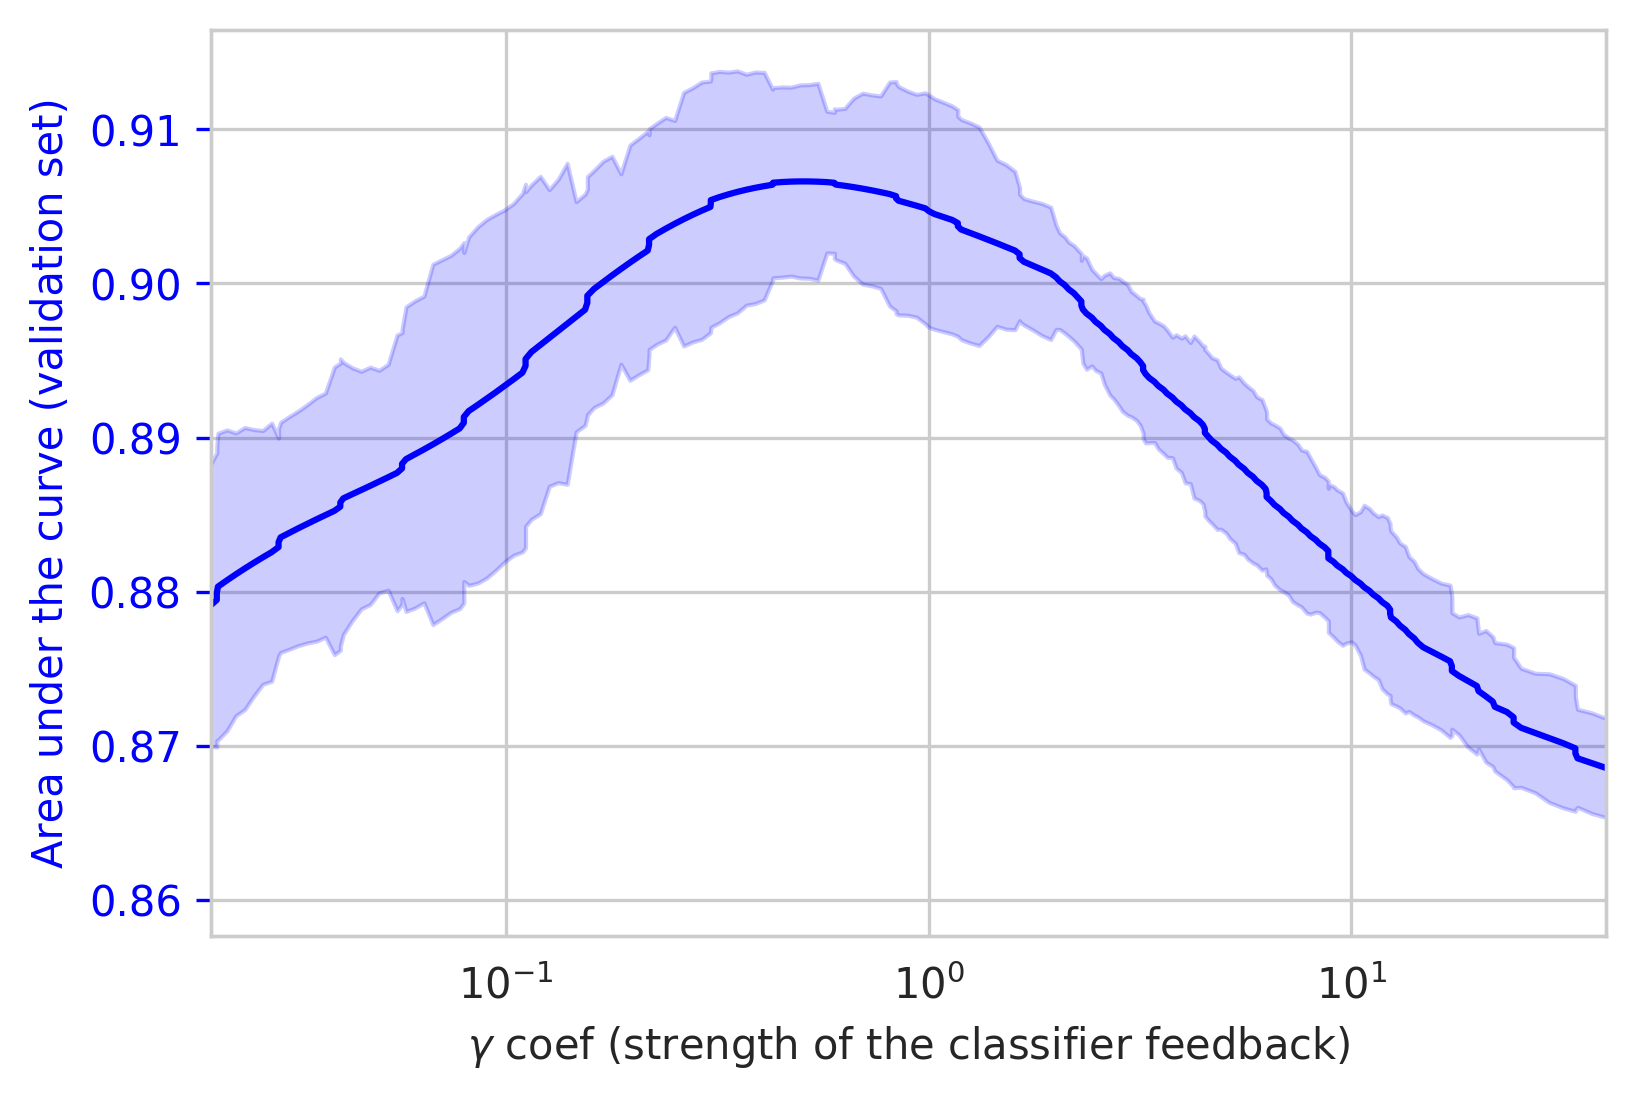

In [75]:
n = 20
fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[-1].set_yticks(ticks=[])

# And finally we get to plot things...
colors = ('Red', 'Blue', 'Green')

values = np.array([x[0] for x in preds])
fvalues = gaussian_filter1d(values[1:],n, mode="nearest")
errors = np.array([np.std(values[i:i+n]) for i in range(1,len(values)-n)])/2
axes[0].plot(gammas[1:], gaussian_filter1d(values[1:], n,  mode="nearest"), c="blue")
axes[0].fill_between(gammas[n//2+1:-n//2], fvalues[n//2:-n//2]-errors, fvalues[n//2:-n//2]+errors, color="blue", alpha = 0.2)
axes[0].set_ylabel('Area under the curve (validation set)' , color=colors[1])
axes[0].tick_params(axis='y', colors=colors[1])


plt.xscale("log")
plt.xlim(0.02,40)
axes[0].set_xlabel("$\gamma$ coef (strength of the classifier feedback)")
#plt.legend(["Spearmanr", "Classifier", "Classifier Retrained"])
plt.show()


## Model Validation

In [10]:
best_epoch = 360
model_rbm.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")

In [69]:
model_rbm.eval()
model_rbm.ais()

4.912878036499023

In [14]:
model_rbm.val(train_loader, visible_layers, hidden_layers, 0)
model_rbm.val_classifier(train_loader_labelled, visible_layers, hidden_layers, 0)

Val Epoch: 0 [100%] || Time: 0 min 0 || P(v): -0.503 || P(v,h): -0.638 || PI: 0.712
Val SSL Epoch: 0 [100%] || Time: 0 min 0 || P(v): -0.583 || P(v,h): -0.717 || PI: 0.722 || PAM: 0.889


In [15]:
model_rbm.val(val_loader, visible_layers, hidden_layers, 0)
model_rbm.val_classifier(val_loader_labelled, visible_layers, hidden_layers, 0)

Val Epoch: 0 [100%] || Time: 0 min 0 || P(v): -0.603 || P(v,h): -0.737 || PI: 0.707
Val SSL Epoch: 0 [100%] || Time: 0 min 0 || P(v): -0.930 || P(v,h): -1.055 || PI: 0.731 || PAM: 0.985


In [72]:
model_rbm = model_rbm.to("cpu")
device = "cpu"